In [1]:
%pylab inline
#Import code from previous videos:
from part6 import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
NN = NeuralNetwork()

In [3]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

In [4]:
X

array([[  3. ,   5. ],
       [  5. ,   1. ],
       [ 10. ,   2. ],
       [  6. ,   1.5]])

In [5]:
y

array([[ 75.],
       [ 82.],
       [ 93.],
       [ 70.]])

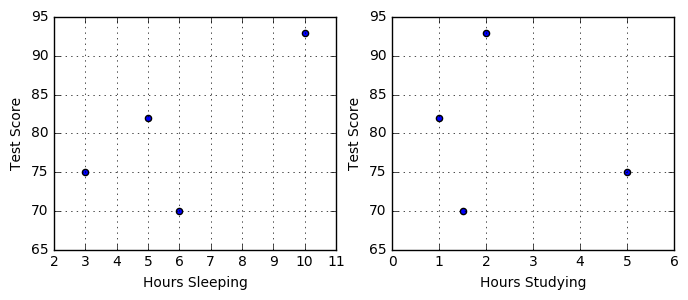

In [6]:
#Plot projections of our new data:
fig = figure(0,(8,3))

subplot(1,2,1)
scatter(X[:,0], y)
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(1,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')

In [7]:
X

array([[  3. ,   5. ],
       [  5. ,   1. ],
       [ 10. ,   2. ],
       [  6. ,   1.5]])

In [8]:
y

array([[ 75.],
       [ 82.],
       [ 93.],
       [ 70.]])

In [9]:
#Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

In [10]:
X

array([[ 0.3,  1. ],
       [ 0.5,  0.2],
       [ 1. ,  0.4],
       [ 0.6,  0.3]])

In [11]:
y

array([[ 0.75],
       [ 0.82],
       [ 0.93],
       [ 0.7 ]])

In [12]:
#Train network with new data:
T = Trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 131
         Function evaluations: 148
         Gradient evaluations: 148


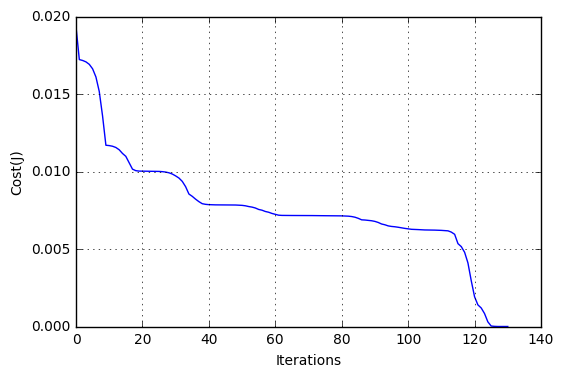

In [13]:
#Plot cost during training:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost(J)')

In [14]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [15]:
allOutputs = NN.forwardPropagation(allInputs)

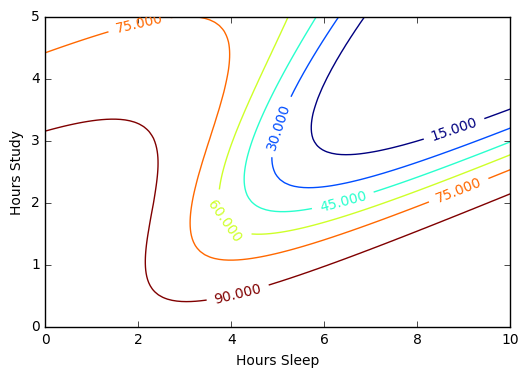

In [16]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

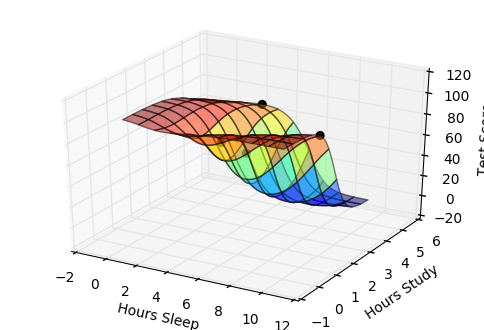

In [17]:
#3D plot:
#Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#Scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

In [18]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [19]:
##Need to modify trainer class a bit 
##to check testing error during training:
class Trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))     
        self.W.append(params) # weights numpy array
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)    
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY  
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        #Make empty list to store weights update:
        self.W =[]
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, \
                                 jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, \
                                 callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [21]:
#Train network with new data:
NN = NeuralNetwork()

T = Trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 68
         Gradient evaluations: 68


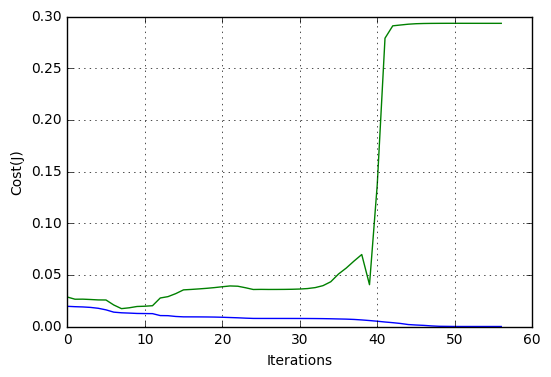

In [22]:
#Plot cost during training:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost(J)')

In [26]:
#Regularization Parameter:
Lambda = 0.0001 

In [29]:
#New complete class, with changes:
class NeuralNetwork(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forwardPropagation(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forwardPropagation(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forwardPropagation(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] +  self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [30]:
NN = NeuralNetwork(Lambda=0.0001)

In [31]:
def computeGradientsCheck(N, X, y):
        paramsInitial = N.getParams()
        chkgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)

            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Check Gradient
            chkgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0

        #Return Params to original value:
        N.setParams(paramsInitial)

        return chkgrad

In [32]:
#Make sure our gradients are correct after making changes:
chkgrad = computeGradientsCheck(NN, X, y)
grad = NN.computeGradients(X,y)

In [33]:
#Should be less than 1e-8:
norm(grad-chkgrad)/norm(grad+chkgrad)

1.9081575053976382e-10

In [34]:
X


array([[ 0.3,  1. ],
       [ 0.5,  0.2],
       [ 1. ,  0.4],
       [ 0.6,  0.3]])

In [35]:
testX

array([[ 4. ,  5.5],
       [ 4.5,  1. ],
       [ 9. ,  2.5],
       [ 6. ,  2. ]])

In [36]:
y

array([[ 0.75],
       [ 0.82],
       [ 0.93],
       [ 0.7 ]])

In [37]:
testY

array([[ 0.7 ],
       [ 0.89],
       [ 0.85],
       [ 0.75]])

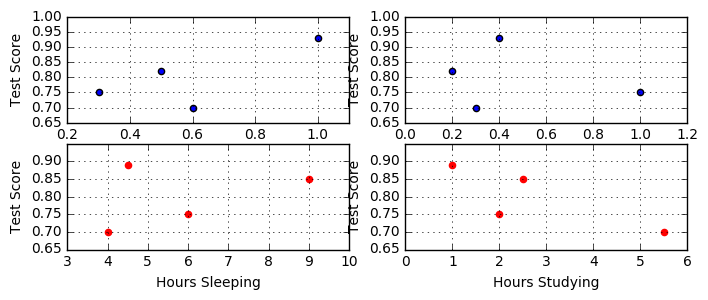

In [38]:
#Plot projections of our new data:
fig = figure(0,(8,3))

# training data (blue)
subplot(2,2,1)
scatter(X[:,0], y)
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(2,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')

# test data (red)
subplot(2,2,3)
scatter(testX[:,0], testY, color='red')
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(2,2,4)
scatter(testX[:,1], testY, color='red')
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')


In [39]:
T = Trainer(NN)

In [40]:
T.train(X,y,testX,testY)

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 88
         Function evaluations: 91
         Gradient evaluations: 91


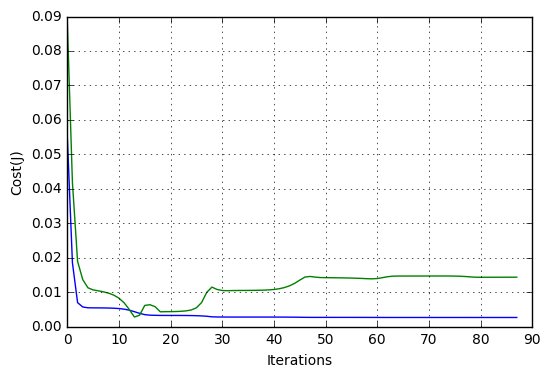

In [41]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost(J)')

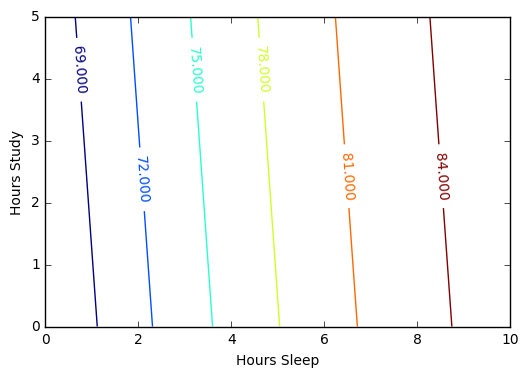

In [42]:
allOutputs = NN.forwardPropagation(allInputs)

#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

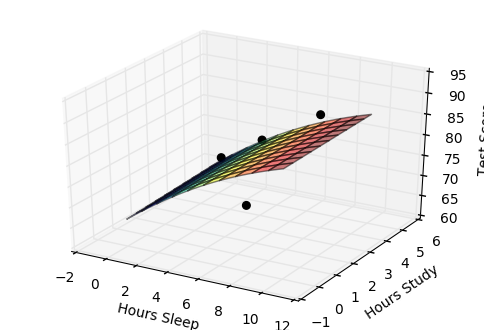

In [43]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

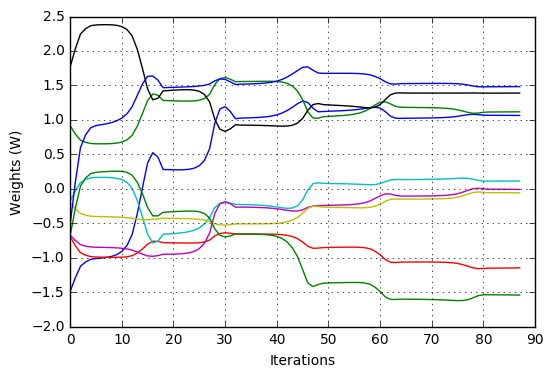

In [44]:
#Plot weights during training:
plot(T.W)
grid(1)
xlabel('Iterations')
ylabel('Weights (W)')